In [1]:
# test of HMM
import numpy as np
import analysis

s = np.array([0, 0, 1, 0, 2, 2, 2])
n = 3
m = 4
seq = np.array(
    [
        [0, 1, 1, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 1],
        [1, 1, 0, 0],
        [0, 1, 0, 1],
    ]
)

hmm = analysis.HMM4binary_sensors()
hmm.fit_with_true_hidden_states(seq, s)
print(hmm.predict_states(seq))
print(hmm.A)
print(hmm.P)

(array([0, 1, 0, 2, 2, 2, 2]), 5.873606637142921e-07)
[[0.33333333 0.33333333 0.33333333]
 [1.         0.         0.        ]
 [0.         0.         1.        ]]
[[0.         0.66666667 0.66666667 0.33333333]
 [0.         0.         1.         0.        ]
 [0.66666667 0.66666667 0.         0.66666667]]


In [3]:
import numpy as np
import analysis

C = np.array([1 / 2, 1 / 2])
A = np.array([[1 / 4, 3 / 4], [1 / 4, 3 / 4]])
P = np.array([[4 / 5, 1 / 5], [1 / 5, 2 / 3]])
s = np.random.randint(0, 2)
states = [s]
data = [[np.random.binomial(1, P[s][0]), np.random.binomial(1, P[s][1])]]
for i in range(10000):
    flag = np.random.binomial(1, A[s][0])
    if s == 0:
        if not (flag):
            s = 1
    else:
        if flag:
            s = 0
    states.append(s)
    data.append([np.random.binomial(1, P[s][0]), np.random.binomial(1, P[s][1])])
states = np.array(states)
data = np.array(data)

hmm = analysis.HMM4binary_sensors()
hmm.fit_with_true_hidden_states(data, states)
print(hmm.C)
print(hmm.A)
print(hmm.P)

[0. 1.]
[[0.25408204 0.74591796]
 [0.25023368 0.74976632]]
[[0.79299363 0.21218153]
 [0.20269729 0.67071705]]


In [148]:
# test of trajectory calculation

import math


def angle_cost(angle_diff):
    if angle_diff > 3 / 4 * math.pi:
        return 200
    elif angle_diff > math.pi / 4:
        return 75
    elif angle_diff > math.pi / 12:
        return (180 * angle_diff / math.pi) ** 2 / 45
    else:
        return (180 * angle_diff / math.pi) / 3


numpy_angle_cost = np.vectorize(angle_cost)

g_L, g_W = 5, 5
distance = np.arange(156).reshape((13, 12))
discomfort = np.arange(156).reshape((13, 12)) + 2
M, N = distance.shape
I, J = 6, 8

# print(cost.astype(np.int32))
max_ii, max_jj = 6, 6
min_ii, min_jj = 2, 2

start_i = max(0, I - max_ii + 1)
end_i = min(I + max_ii, M)
start_j = max(0, J - max_jj + 1)
end_j = min(J + max_jj, N)
print(f"start_i:{start_i}, end_i:{end_i}")
print(f"start_j:{start_j}, end_j:{end_j}")

m, n = end_i - start_i, end_j - start_j
print(f"m:{m}, n:{n}")

cost = np.full((m, n), 99999.0)
column_index, row_index = np.meshgrid(np.arange(n), np.arange(m))
row_index += start_i
column_index += start_j

mask = np.full((m, n), True)
mask[
    max(0, I - min_ii) - start_i : min(I + min_ii + 1, M) - start_i,
    max(0, J - min_jj) - start_j : min(J + min_jj + 1, N) - start_j,
] = False
print(mask)
# (1) weighted distance from the next position to the any points in the target area
cost[mask] = distance[row_index, column_index][mask]
print(cost.astype(np.int32))

# (2) weighted distance (with discomfort caused by nearby obstacles) from the position to the next position
_temp_row_index = I + (row_index - I) // 2
_temp_column_index = J + (column_index - J) // 2
discomfort_on_half_position = discomfort[_temp_row_index, _temp_column_index]
# approximate discomfort value between the present postion and the next postion
mean_discomfort = (
    discomfort[I][J] + discomfort[row_index, column_index] + discomfort_on_half_position
) / 3
length_matrix = np.sqrt(
    np.square((row_index - I) * g_L) + np.square((column_index - J) * g_W)
)
cost += mean_discomfort * length_matrix

# (3) discomfort caused by the resident changing his/her walking direction
if angle != None:
    radian = np.arctan2(column_index - J, row_index - I)
    diff = np.abs(radian - math.atan2(angle[1], angle[0]))
    acute_diff_angle = np.minimum(diff, 2 * math.pi - diff)
    cost += numpy_angle_cost(acute_diff_angle)

# (4) resident’s most suitable walking stride length
cost += np.square(length_matrix - stride) / 4

# (5) noise
cost += 2 * np.random.rand(m, n)

# select the next step
if np.min(cost) >= 99999:
    raise ValueError("Any position is not possible to move.")
print(cost.astype(np.int32))
min_index_2d = np.unravel_index(np.argmin(cost), cost.shape)
next_pos = (start_i + min_index_2d[0], start_j + min_index_2d[1])
II, JJ = next_pos[0] - I, next_pos[1] - J
print(II, JJ)
print(next_pos)

start_i:1, end_i:12
start_j:3, end_j:12
m:11, n:9
[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True False False False False False  True]
 [ True  True  True False False False False False  True]
 [ True  True  True False False False False False  True]
 [ True  True  True False False False False False  True]
 [ True  True  True False False False False False  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]]
[[   15    16    17    18    19    20    21    22    23]
 [   27    28    29    30    31    32    33    34    35]
 [   39    40    41    42    43    44    45    46    47]
 [   51    52    53 99999 99999 99999 99999 99999    59]
 [   63    64    65 99999 99999 99999 99999 99999    71]
 [   75    76    77 99999 99999 99999

In [147]:
import math


def angle_cost(angle_diff):
    if angle_diff > 3 / 4 * math.pi:
        return 200
    elif angle_diff > math.pi / 4:
        return 75
    elif angle_diff > math.pi / 12:
        return (180 * angle_diff / math.pi) ** 2 / 45
    else:
        return (180 * angle_diff / math.pi) / 3


numpy_angle_cost = np.vectorize(angle_cost)
cost = np.full((M, N), 99999.0)
g_L, g_W = 5, 5
distance = np.arange(156).reshape((13, 12))
discomfort = np.arange(156).reshape((13, 12)) + 2
M, N = distance.shape
I, J = 6, 8

# print(cost.astype(np.int32))
max_ii, max_jj = 6, 6
min_ii, min_jj = 2, 2

mask = np.full((M, N), False)
mask[
    max(0, I - max_ii + 1) : min(I + max_ii, M),
    max(0, J - max_jj + 1) : min(J + max_jj, N),
] = True
mask[
    max(0, I - min_ii) : min(I + min_ii + 1, M),
    max(0, J - min_jj) : min(J + min_jj + 1, N),
] = False
cost[mask] = distance[mask]
print(cost.astype(np.int32))

# (2) weighted distance (with discomfort caused by nearby obstacles) from the position to the next position
column_index, row_index = np.meshgrid(np.arange(N), np.arange(M))
_temp_row_index = I + (row_index - I) // 2
_temp_column_index = J + (column_index - J) // 2
discomfort_on_half_position = discomfort[_temp_row_index, _temp_column_index]
# approximate discomfort value between the present postion and the next postion
mean_discomfort = (discomfort[I][J] + discomfort + discomfort_on_half_position) / 3
length_matrix = np.sqrt(
    np.square((row_index - I) * g_L) + np.square((column_index - J) * g_W)
)
cost += mean_discomfort * length_matrix

angle = (1, 1)
stride = 20
# (3) discomfort caused by the resident changing his/her walking direction
if angle != None:
    radian = np.arctan2(column_index - J, row_index - I)
    diff = np.abs(radian - math.atan2(angle[1], angle[0]))
    acute_diff_angle = np.minimum(diff, 2 * math.pi - diff)
    cost += numpy_angle_cost(acute_diff_angle)

# (4) resident’s most suitable walking stride length
cost += np.square(length_matrix - stride) / 4

# (5) noise
cost += 2 * np.random.rand(M, N)

print(discomfort)
print(discomfort_on_half_position)
print(length_matrix.astype(np.int32))
print(numpy_angle_cost(acute_diff_angle).astype(np.int32))
print((np.square(length_matrix - stride) / 4).astype(np.int32))

[[99999 99999 99999 99999 99999 99999 99999 99999 99999 99999 99999 99999]
 [99999 99999 99999    15    16    17    18    19    20    21    22    23]
 [99999 99999 99999    27    28    29    30    31    32    33    34    35]
 [99999 99999 99999    39    40    41    42    43    44    45    46    47]
 [99999 99999 99999    51    52    53 99999 99999 99999 99999 99999    59]
 [99999 99999 99999    63    64    65 99999 99999 99999 99999 99999    71]
 [99999 99999 99999    75    76    77 99999 99999 99999 99999 99999    83]
 [99999 99999 99999    87    88    89 99999 99999 99999 99999 99999    95]
 [99999 99999 99999    99   100   101 99999 99999 99999 99999 99999   107]
 [99999 99999 99999   111   112   113   114   115   116   117   118   119]
 [99999 99999 99999   123   124   125   126   127   128   129   130   131]
 [99999 99999 99999   135   136   137   138   139   140   141   142   143]
 [99999 99999 99999 99999 99999 99999 99999 99999 99999 99999 99999 99999]]
[[  2   3   4   5   6   

In [ ]:
mat = np.zeros((10, 5))
mat[1, 0] = 1
mat[4, 3] = 1
mat[4, 4] = 1
mat[5, 1] = 1
nrt, valid_sensor_ids = analysis.nonresponse_time_sliding(mat, [], 1, 5, _type = "max_time")
print(mat)
print()
print(nrt)

In [2]:
import statistics
import pandas as pd
import src.utils as utils

def add_milliseconds(time_str):
    # check whether the time_str has milli seconds like 09:22:15
    if '.' not in time_str:
        return time_str + '.0'
    else:
        return time_str
    
def check_begin_end_pattern(df):
    for i, d in df.iterrows():
        status = None
        act = d['activity']
        if isinstance(act, str):
            if 'begin' in act:
                if isinstance(status, str):
                    if status != 'end':
                        raise ValueError("not end - begin")
                status = 'begin'
            elif 'end' in act:
                if isinstance(status, str):
                    if status != 'start':
                        raise ValueError("not start - end")
                status = 'end'

def initial_sensor_dict(sensor_names):
    _dict = {}
    for sensor in sensor_names:
        _dict[sensor] = None
    return _dict

def statistics_text(title, numbers):
    text = ""
    if len(numbers) >= 2:
        unit = "[sec.]"
        text += f"---{title}--------------\n"
        text += f"count: {len(numbers)}\n"
        text += f"mean: {statistics.mean(numbers)} {unit}\n"
        text += f"std: {statistics.stdev(numbers)} {unit}\n"
        text += f"min: {min(numbers)} {unit}\n"
        text += f"max: {max(numbers)} {unit}\n"
    return text

# import CASAS Aruba data
data = []
with open('data', 'r') as f:
    for line in f:
        data.append(line.strip())

df = pd.DataFrame(data, columns=['raw'])
df[['date', 'time', 'sensor_id', 'status', 'activity']] = df['raw'].str.split(expand=True, n=4)
df['time'] = df['time'].apply(add_milliseconds)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.drop(['date', 'time', 'raw'], axis=1, inplace=True)
# check_begin_end_pattern  # passed
# fill None in activity as the before activity
# print(df)

# Create a new DataFrame containing only status changes to identify state transitions
df = df[df['status'].isin(['ON', 'OFF'])]
df = df.reset_index(drop=True)

df_activity_names = df.dropna(subset=['activity'])
df_activity_names['activity_base'] = df_activity_names['activity'].str.replace(' begin', '').str.replace(' end', '')
activity_names = set(df_activity_names['activity_base'].unique())
sensor_names = set(df['sensor_id'].unique())

states = ['ON to OFF', 'OFF to ON']
duration_dict = {}
for activity in activity_names:
    for sensor in sensor_names:
        for state in states:
            key = (activity, sensor, state) 
            duration_dict[key] = []

in_activity = False
temp_sensor_dict = initial_sensor_dict(sensor_names)

for i, d in df.iterrows():
    utils.print_progress_bar(df.shape[0]-1, i, "", 10000)
    activity_status, sensor, state, date_time = d['activity'], d['sensor_id'], d['status'], d['datetime']
    if (activity_status is not None):
        activity = activity_status.replace(' begin', '').replace(' end', '')
        if 'begin' in activity_status:
            temp_sensor_dict = initial_sensor_dict(sensor_names)
            in_activity = True
        elif 'end' in activity_status:
            past_activity = activity
            in_activity = False
    if in_activity:
        past_date_time = temp_sensor_dict[sensor]
        if 'ON' in state:
            if past_date_time is not None:
                duration_seconds = (date_time - past_date_time).total_seconds()
                if duration_seconds > 0:
                    duration_dict[(activity, sensor, 'OFF to ON')].append(duration_seconds)
            temp_sensor_dict[sensor] = date_time
        if 'OFF' in state:
            if past_date_time is not None:
                duration_seconds = (date_time - past_date_time).total_seconds()
                if duration_seconds > 0:
                    duration_dict[(activity, sensor, 'ON to OFF')].append(duration_seconds)
            temp_sensor_dict[sensor] = date_time

with open('output.txt', 'w') as f:
    for activity in activity_names:
        for sensor in sensor_names:
            for state in states:
                key = (activity, sensor, state)
                title = activity + " " + sensor + " " + state
                line = statistics_text(title, duration_dict[key])
                # print(line)
                f.write(line + '\n')

C:\Users\tanakai\AppData\Local\Temp\ipykernel_4848\1108684952.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_activity_names['activity_base'] = df_activity_names['activity'].str.replace(' begin', '').str.replace(' end', '')


 1595986 / 1595986. Completed!


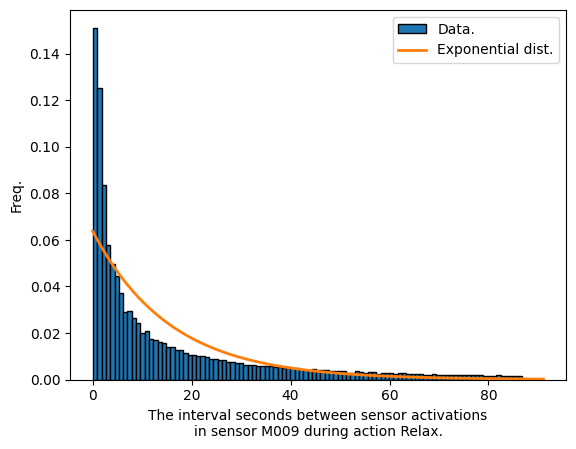

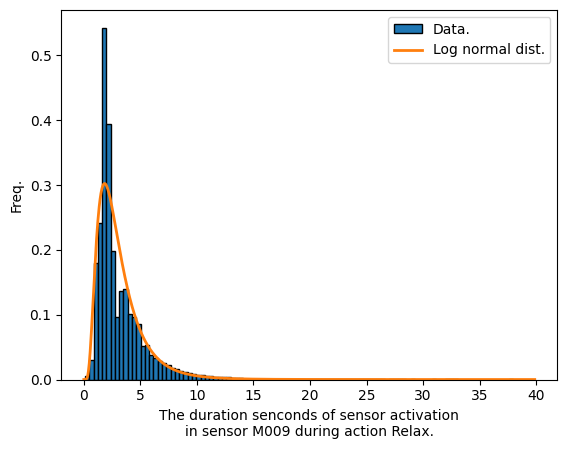

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, expon, lognorm

def draw_histogram_with_exponential_dist(numbers, x_label, save_title):
    plt.hist(numbers, bins=100, edgecolor='black', density=True, label = "Data.")
    xmin, xmax = plt.xlim()
    x = np.linspace(0, xmax, 1000)
    mean = np.mean(np.array(numbers))
    expon_data = expon.pdf(x, scale = mean)  # scale = 1/lambda
    plt.plot(x, expon_data, 'tab:orange', linewidth=2, label = 'Exponential dist.')
    plt.xlabel(x_label)
    plt.ylabel('Freq.')
    plt.legend()
    plt.savefig(save_title, bbox_inches="tight")
    plt.show()
    plt.close()


def draw_histogram_with_log_norm_dist(numbers, x_label, save_title):
    plt.hist(numbers, bins=100, edgecolor='black', density=True, label = "Data.")
    xmin, xmax = plt.xlim()
    x = np.linspace(0, xmax, 1000)
    log_numbers = np.log(np.array(numbers))

    # Parameters for the lognormal distribution
    mean = np.mean(log_numbers)  # Mean on the log scale
    sigma = np.std(log_numbers)  # Standard deviation on the log scale

    # mu, std = norm.fit(numbers)
    log_norm_data = lognorm.pdf(x, s=sigma, scale=np.exp(mean))
    plt.plot(x, log_norm_data, 'tab:orange', linewidth=2, label = 'Log normal dist.')
    plt.xlabel(x_label)
    plt.ylabel('Freq.')
    plt.legend()
    plt.savefig(save_title, bbox_inches="tight")
    plt.show()
    plt.close()



def delete_outlier_value(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]

activity = "Relax"
sensor = "M009"
status = "OFF to ON"
key = (activity, sensor, status)
numbers = duration_dict[key]
numbers = delete_outlier_value(numbers)
x_label = f"The interval seconds between sensor activations\nin sensor {sensor} during action {activity}."
save_title = f"{activity}_{sensor}_{status}.png"
draw_histogram_with_exponential_dist(numbers, x_label, save_title)


activity = "Relax"
sensor = "M009"
status = "ON to OFF"
key = (activity, sensor, status)
numbers = duration_dict[key]
numbers = sorted(numbers)[:-2]
x_label = f"The duration senconds of sensor activation\nin sensor {sensor} during action {activity}."
save_title = f"{activity}_{sensor}_{status}.png"
draw_histogram_with_log_norm_dist(numbers, x_label, save_title)